In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC

In [346]:
df_week = pd.read_csv("SAP_weekly_return_volatility.csv")
df_week.head(5)

,Year,Week_Number,mean_return,volatility,label
0,2019,0,-0.1050,3.594650,0
1,2019,1,0.6532,1.153409,1
2,2019,2,0.7326,1.198802,1
3,2019,3,0.0735,1.593999,0
4,2019,4,-0.3746,2.056743,0


In [347]:
df_daily = pd.read_csv("SAP_weekly_return_volatility_detailed.csv")
df_daily.head(5)

,High,Low,Open,Close,Volume,Adj Close,Return,Date,Week_Number,Year,Day,Weekday,mean_return,volatility
0,99.559998,98.339996,98.570000,99.180000,506300.0,94.896118,0.000,2019-01-02,0,2019,2,Wednesday,-0.1050,3.594650
1,96.830002,95.449997,96.730003,95.459999,807800.0,91.336800,-3.751,2019-01-03,0,2019,3,Thursday,-0.1050,3.594650
2,99.199997,96.910004,97.339996,98.739998,1038100.0,94.475128,3.436,2019-01-04,0,2019,4,Friday,-0.1050,3.594650
3,100.190002,98.760002,99.440002,99.709999,861600.0,95.403229,0.982,2019-01-07,1,2019,7,Monday,0.6532,1.153409
4,101.480003,100.430000,101.370003,101.269997,548600.0,96.895844,1.565,2019-01-08,1,2019,8,Tuesday,0.6532,1.153409


In [348]:
df_week_2019 = df_week[df_week["Year"] == 2019].reset_index(drop = True)
df_week_2020 = df_week[df_week["Year"] == 2020].reset_index(drop = True)

### 1. take N = 1,...,10 and d = 1,2,...,5. For each value of N and d construct a random tree classifier (use ”entropy” as splitting criteria - this is the default) use your year 1 labels as training set and compute the error rate for year 2. Plot your error rates and find the best combination of N and d.

In [349]:
def rdf(x_train, x_test, y_train, y_test, n, d):
    
    model = RFC(n_estimators = n, max_depth = d, criterion = "entropy")
    model.fit(x_train,y_train)
    
    predicted = model.predict(x_test)
    accuracy = np.mean(y_test == predicted)
    
    return [predicted, accuracy]

In [350]:
x_tr_1, x_te_2, y_tr_1, y_te_2  = train_test_split(df_week_2019[["mean_return","volatility"]].values,\
                                     df_week_2019["label"].values, test_size = 0.5,random_state=0)

In [351]:
rdf_dict = dict()

for n in range(1,11):
    accuracy_list = list()
    for d in range(1,6):
        key = str(n) + str(d)
        return_value = rdf(x_tr_1, x_te_2, y_tr_1, y_te_2, n, d)
        accuracy_list.append(round(return_value[1],3))
        
    rdf_dict[n] = accuracy_list 

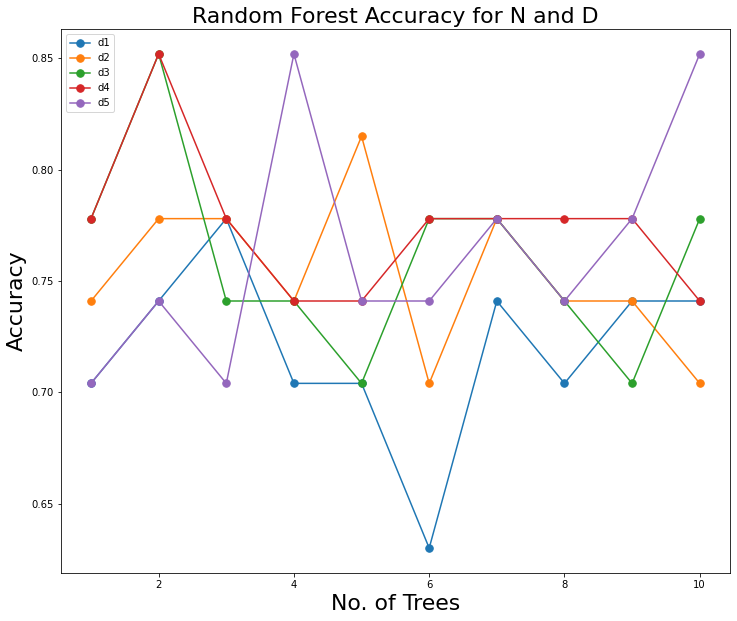

In [352]:
df_random_forest = pd.DataFrame(rdf_dict, index = ["d1","d2","d3","d4","d5"]).T
df_random_forest.plot(figsize = (12,10), marker = ".", markersize=15)
plt.xlabel("No. of Trees", fontsize = 22)
plt.ylabel("Accuracy", fontsize = 22)
plt.title("Random Forest Accuracy for N and D", fontsize = 22)
plt.show()

##### As be we can see in the above plot we have lot of points which are giving the same result accuracy as .85. Hence, we will choose N = 2 and d = 4 to compute data for year 2.

### 2. using the optimal values from year 1, compute the confusion matrix for year 2

In [372]:
x1 = df_week_2019[["mean_return","volatility"]].values
y1 = df_week_2019["label"].values
x2 = df_week_2020[["mean_return","volatility"]].values
y2 = df_week_2020["label"].values

random_forest_2020 = rdf(x1, x2, y1, y2, 2, 4)

In [373]:
tn, fp, fn, tp = confusion_matrix(y2, random_forest_2020[0]).ravel()
pd.DataFrame([tn, fp, fn, tp], index = ["TN","FP","FN","TP"]).T

,TN,FP,FN,TP
0,33,0,8,12


### 3. what is true positive rate and true negative rate for year 2?

In [374]:
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"TPR:{tpr:.2f} and TNR:{tnr:.2f}")

TPR:0.60 and TNR:1.00


### 4. implement a trading strategy based on your labels for year 2 and compare the performance with the ”buy-and-hold” strategy. Which strategy results in a larger amount at the end of the year?

In [375]:
df_week_2020["predict"] = random_forest_2020[0]
df_daily_2 = df_daily[(df_daily["Year"] == 2020)].copy().reset_index(drop=True)

#### Buy and Hold

In [376]:
def buyhold(ret_list):
    ret = round(((ret_list / 100) + 1).cumprod() * 100,2)
    
    return ret

In [377]:
hold = buyhold(df_daily[(df_daily["Year"] == 2020)]["Return"])
hold.values[-1]

98.71

#### My Strategy

In [378]:
def compute_daily_ret(d_frame1, amt):
    ret = round(((d_frame1["Return"] / 100) + 1).cumprod() * amt,2)

    return round(ret.values[-1],2)

In [379]:
def weekDaily(d_frame_week,d_frame_daily,lbl):
    total_ret = list()
    for i in range(len(d_frame_week)):
        if i > 0:
            year = d_frame_week.loc[i]["Year"]

            week = d_frame_week.loc[i]["Week_Number"]

            prv_week = d_frame_week.loc[i - 1]["Week_Number"]

            frame = d_frame_daily[(d_frame_daily["Week_Number"] == week)]

            if d_frame_week.loc[i - 1][lbl] == 0 and d_frame_week.loc[i][lbl] == 1:

                amount = total_ret[i - 1] 
                total_ret.append(compute_daily_ret(frame, amount))
                
            elif d_frame_week.loc[i - 1][lbl] == 1 and d_frame_week.loc[i][lbl] == 1:

                amount = total_ret[i - 1]
                total_ret.append(compute_daily_ret(frame, amount))
            else:
                total_ret.append(total_ret[i - 1])
        else:     
            total_ret.append(100)
    return total_ret

In [380]:
daily_ret = weekDaily(df_week_2020,df_daily_2,"predict")
daily_ret[-1]

156.78

In [381]:
print(f"""
2020 return using Buy and Hold: $ {hold.values[-1]} and 
2020 return using Random Forest: $ {daily_ret[-1]}
""")


2020 return using Buy and Hold: $ 98.71 and 
2020 return using Random Forest: $ 156.78

